# Denoising corrupted digit images with Denoising AutoEncoder (Pytorch)

### 1) Mnist dataset were used

### 2) The datasets were scaled by dividing 255 and splited into different datasets

### 3) Dead pixel were generated with the cunstom "add_noise" function

### 4) DeepAutoEncoder (28*28r-35*35r-28*28r) were built with the help of Pytorch library

### 5) MSELoss and Adam were chose as the loss function and optimizer 

### 6) Custom "train_model" function were built to help us obtain the train,  test losses and also the reconstructions

### 7) Corrupted images were sucessfully recovered 

In [1]:
# import ecos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
# import datasets
train = pd.read_csv('/Users/hindy/jupyter/digit-recognizer/train.csv')
test = pd.read_csv('/Users/hindy/jupyter/digit-recognizer/test.csv')

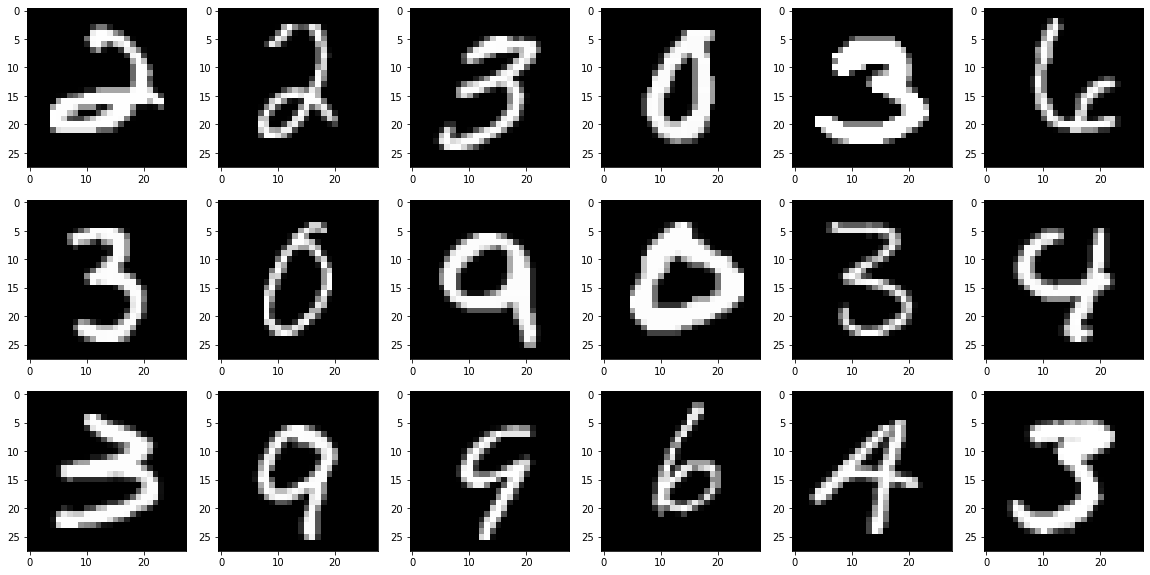

In [3]:
# inspecting our digits
fig, ax = plt.subplots(3, 6, figsize=(20, 10))
ax = ax.flatten()
for i in range(18):
    ran_idx = np.random.choice(len(train))
    ax[i].imshow(np.array(train.iloc[ran_idx, 1:]).reshape(28, 28), cmap='gray')

In [4]:
X = train.drop('label', axis=1)
y = train['label']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=42)
X_test = test

In [6]:
# scaling our images
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [8]:
# custom fn to generate dead pixels
def add_noise(df, likelihood=.5):
    df = df.copy()
    for col in df.columns:
        sample = df[col].sample(frac=likelihood)
        df[col].loc[sample.index] = 0
        
    return df

noisy_X_train = add_noise(X_train)
noisy_X_val = add_noise(X_val)

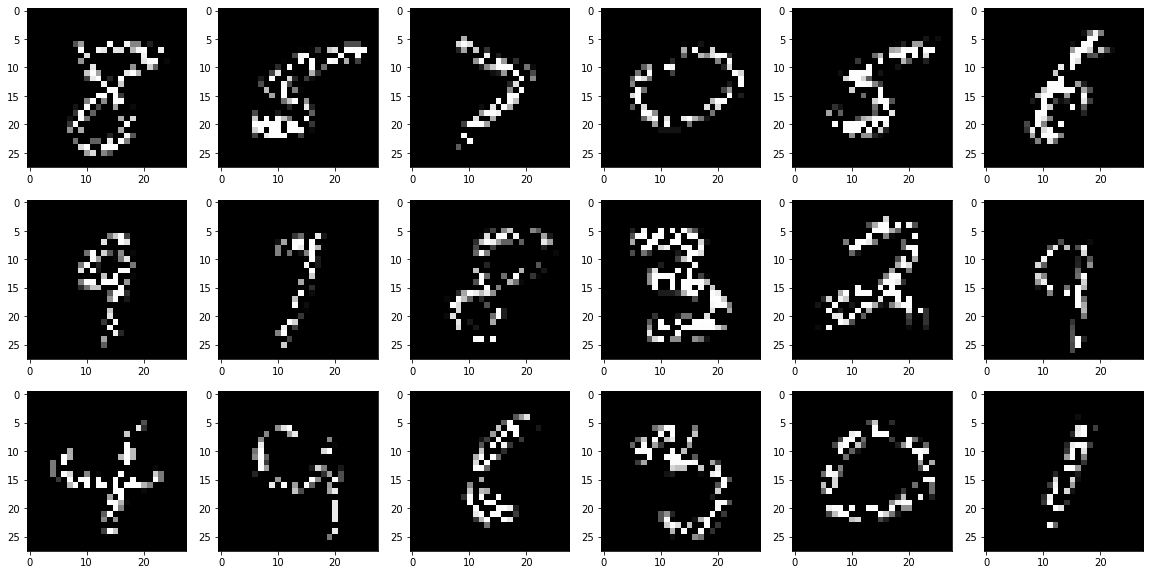

In [9]:
# a sneek peak to our noisy images
fig, ax = plt.subplots(3, 6, figsize=(20, 10))
ax = ax.flatten()
for i in range(18):
    ran_idx = np.random.choice(len(noisy_X_train))
    ax[i].imshow(np.array(noisy_X_train.iloc[ran_idx, :]).reshape(28, 28), cmap='gray')

### Since the likelihood was set to .5, there should be exactly 50% chance that a pixel is dead.

In [10]:
# turning the datasets into torch.tensor with sequence unpacking
X_train, X_val, X_test, noisy_X_train, noisy_X_val = (torch.from_numpy(np.array(df).astype(np.float32)) for df in [X_train, X_val, X_test, noisy_X_train, noisy_X_val])
y_train, y_val = (torch.from_numpy(np.array(df).astype(np.float32).reshape(-1, 1)) for df in [y_train, y_val])

In [11]:
# our denosing autoencoder
class DeepAutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2):
        super(DeepAutoEncoder, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1), 
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim2, encoding_dim1), 
            nn.SELU(), # Since ReLu's zero output might cause trouble
            nn.Linear(encoding_dim1, input_dim))
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
import time

In [19]:
# specifying our initial parameters
model = DeepAutoEncoder(28*28, 35*35, 28*28)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters())

epochs = 1000

# custim "train_model" fn
def train_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for t in range(epochs):
        start = time.time()
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # Forward pass: Compute predicted y by passing x to the model
        y_train_pred = model(X_train)

        # Compute train loss
        loss = criterion(y_train_pred, y_train)

        loss.backward()
        optimizer.step()

        # test losses
        y_test_pred = model(X_test)
        test_loss = criterion(y_test_pred, y_test)

        # store losses
        train_losses[t] = loss.item()
        test_losses[t] = test_loss.item()
        
        time_spent = round((time.time() - start)/60, 4)
        if (t + 1) % 50 ==0:
            print(f'Epoch {t+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f} Time Spent: {time_spent}')
            
    return train_losses, test_losses, y_test_pred

In [20]:
# storing our train, test losses and recovered images
train_losses, test_losses, y_test_pred = train_model(noisy_X_train, X_train, noisy_X_val, X_val, model, criterion, optimizer, epochs)

Epoch 50/1000, Train Loss: 0.0315, Test Loss: 0.0315 Time Spent: 0.2918
Epoch 100/1000, Train Loss: 0.0215, Test Loss: 0.0221 Time Spent: 0.2904
Epoch 150/1000, Train Loss: 0.0180, Test Loss: 0.0191 Time Spent: 0.2917
Epoch 200/1000, Train Loss: 0.0160, Test Loss: 0.0179 Time Spent: 0.2919
Epoch 250/1000, Train Loss: 0.0144, Test Loss: 0.0166 Time Spent: 0.2902
Epoch 300/1000, Train Loss: 0.0135, Test Loss: 0.0163 Time Spent: 0.2919
Epoch 350/1000, Train Loss: 0.0126, Test Loss: 0.0158 Time Spent: 0.2919
Epoch 400/1000, Train Loss: 0.0120, Test Loss: 0.0157 Time Spent: 0.2907
Epoch 450/1000, Train Loss: 0.0115, Test Loss: 0.0155 Time Spent: 0.2905
Epoch 500/1000, Train Loss: 0.0111, Test Loss: 0.0156 Time Spent: 0.2905
Epoch 550/1000, Train Loss: 0.0107, Test Loss: 0.0154 Time Spent: 0.2918
Epoch 600/1000, Train Loss: 0.0104, Test Loss: 0.0154 Time Spent: 0.292
Epoch 650/1000, Train Loss: 0.0101, Test Loss: 0.0154 Time Spent: 0.2914
Epoch 700/1000, Train Loss: 0.0101, Test Loss: 0.0157

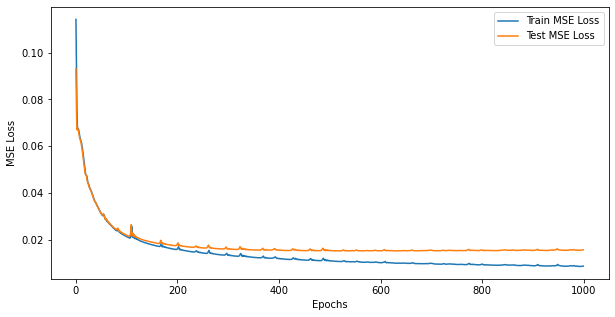

In [21]:
# our elbow curves
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(test_losses)
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend(['Train MSE Loss', 'Test MSE Loss'])
plt.show()

### The loss differences between the trainset and testset are so small that 
### we can conclude there is no overfitting whatsoever

In [22]:
# detaching our images from the pytorch land
y_test_pred_detached = y_test_pred.detach()
y_test_pred_detached_df = pd.DataFrame(np.array(y_test_pred_detached))

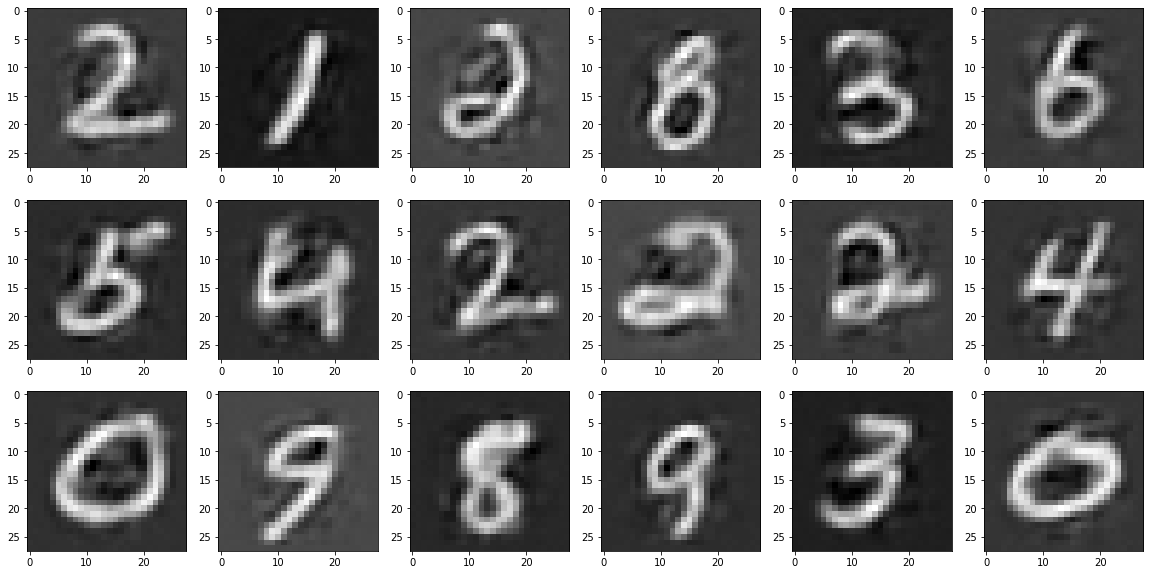

In [23]:
# our recovered images (reconstructions)
fig, ax = plt.subplots(3, 6, figsize=(20, 10))
ax = ax.flatten()
for i in range(18):
    ran_idx = np.random.choice(len(y_test_pred_detached_df))
    ax[i].imshow(np.array(y_test_pred_detached_df.iloc[ran_idx, :]).reshape(28, 28), cmap='gray')

### Although the recovered images are little bit blurry, we can see that the dead pixels were gone.